In [1]:
import hashlib
import os
import pickle
from hwcomponents_cacti import CactiSRAM
from hwcomponents_library import AladdinAdder, AladdinMultiplier

from fastfusion.frontend.architecture import Memory
from fastfusion.frontend.specification import Specification
from fastfusion.mapper.FFM.exploration.mapper_multi_einsum import get_sims
from fastfusion.mapper.simanneal.wrappers import join_sims

import copy
import time
from fastfusion import Specification
from fastfusion.mapper.FFM.exploration.metrics import Metrics
from fastfusion.mapper.FFM.exploration.mapper_multi_einsum import get_sims
from fastfusion.mapper.FFM.joining.sim import SIM
from fastfusion.mapper.FFM.joining.simexplore import join_sims
import fastfusion.mapper.FFM.exploration.mapper_one_einsum as mapper_one_einsum

from fastfusion.mapper.FFM.exploration.mapping_filter_tags.ffmt import get_ffmt_tag
from fastfusion.mapper.FFM.exploration.mapping_filter_tags.onesplit import get_one_split_tag
from fastfusion.mapper.FFM.pareto import PartialMappings

# TODO: Make a setting for the below two in the spec
# TODO: Generate pmappings one Einsum at a time. Once we've made compatibility, check it
# against the previously-generated compatibilities and stop if there's no match.
# TODO: Once the previous is done, also add a forward check. Once the compatibilities of
# a particular Einsum are generated, we can immediately check the previous Einsums.
# TODO: Make the mapping return an object that supports union operators and stuff
# TODO: The fix in mapping.py

# TODO: have inf a supported value in YAMLs
# TODO: programatically check if any storages are below all backing storages. If so,
# don't record reservations for it.
# TODO: If any memroies have size > sum of all tensor sizes, also don't record reservations
# TODO: constrained_loops for  
# TODO: Tile shape check spatial all big or all small-- need to check mixes

objective = lambda df: df['metric_Latency']# * df['metric_Energy']

def get_fused_mappings(
        n_pes,
        pe_x,
        pe_y,
        parameterization="",
        return_mappings=False,
        cache_dir="cache",
    ) -> PartialMappings:
    print(f'Running parameterization {parameterization}')
    cachekey = (n_pes, pe_x, pe_y, parameterization)
    fname = parameterization + " " + hashlib.md5(str(cachekey).encode()).hexdigest()
    if os.path.exists(f"{cache_dir}/{fname}.pkl"):
        print(f"Loading from {cache_dir}: {fname}")
        mappings = pickle.load(open(f"{cache_dir}/{fname}.pkl", "rb"))
        if return_mappings:
            return mappings
        return objective(mappings.data).min(), mappings
    return 0, None




parameterization2edp = {}
parameterization2mappings = {}

parameterizations = [
    "Unfused",
    "FlashAttention A",
    "FlashAttention B",
    "Fixed-Dataflow",
    "FFM"
]

results_keys = [
    "Big-Batch\n256 PEs\n",
    "Big-Batch\n64 PEs",
    "Big-Sequence\n256 PEs",
    "Big-Sequence\n64 PEs",
]
results = {}

for cache_dir in ["cache", "cache2"]:
    for n_pes in [256, 64]:
        parameterization2result = {}
        for p in parameterizations:
            x, _ = get_fused_mappings(n_pes, 128, 128, parameterization=p, cache_dir=cache_dir)
            print(f"{p} {n_pes}x128x128: {x}")
            parameterization2result[p] = x
        results[results_keys.pop(0)] = parameterization2result

Running parameterization Unfused
Loading from cache: Unfused 114baf21aa8bad3448c363dd3fa22dcb
Unfused 256x128x128: 9851491.064479657
Running parameterization FlashAttention A
Loading from cache: FlashAttention A 6217c41e2340fb42c2a248f45bf016eb
FlashAttention A 256x128x128: 8015287.6195324445
Running parameterization FlashAttention B
Loading from cache: FlashAttention B da28c3d5333b367704f0c9c228c4b5d7
FlashAttention B 256x128x128: 7113569.897058836
Running parameterization Fixed-Dataflow
Loading from cache: Fixed-Dataflow 34e1759b4133a10d2522ef29f5d1ee86
Fixed-Dataflow 256x128x128: 5363363.77328432
Running parameterization FFM
Loading from cache: FFM 7072c9201cb1dcdaa906a8409a49e3aa
FFM 256x128x128: 4391360.291855206
Running parameterization Unfused
Loading from cache: Unfused 0aa93e2879c6dfcdbaad0e87d5452835
Unfused 64x128x128: 19531521.16742082
Running parameterization FlashAttention A
Loading from cache: FlashAttention A 6998d3d34c7d3046ca03e6bac17bd720
FlashAttention A 64x128x128:

Elementwise-Only: {'Big-Batch\n256 PEs\n': np.float64(0.44575590264590587), 'Big-Batch\n64 PEs': np.float64(0.8656923265251631), 'Big-Sequence\n256 PEs': np.float64(0.10463342538410497), 'Big-Sequence\n64 PEs': np.float64(0.24975164276758935)}
FlashAttention A: {'Big-Batch\n256 PEs\n': np.float64(0.5478730770875776), 'Big-Batch\n64 PEs': np.float64(0.9555232782582902), 'Big-Sequence\n256 PEs': np.float64(0.5639303203903768), 'Big-Sequence\n64 PEs': np.float64(0.9794748162857275)}
FlashAttention B: {'Big-Batch\n256 PEs\n': np.float64(0.6173215917469019), 'Big-Batch\n64 PEs': np.float64(0.9772558464344522), 'Big-Sequence\n256 PEs': np.float64(0.1862264891959553), 'Big-Sequence\n64 PEs': np.float64(0.40359855000868095)}
Fixed-Dataflow: {'Big-Batch\n256 PEs\n': np.float64(0.8187698014684736), 'Big-Batch\n64 PEs': np.float64(0.9809715837032899), 'Big-Sequence\n256 PEs': np.float64(0.7426655591588243), 'Big-Sequence\n64 PEs': np.float64(0.9845267142058987)}
Fast & Fusiest: {'Big-Batch\n256 P

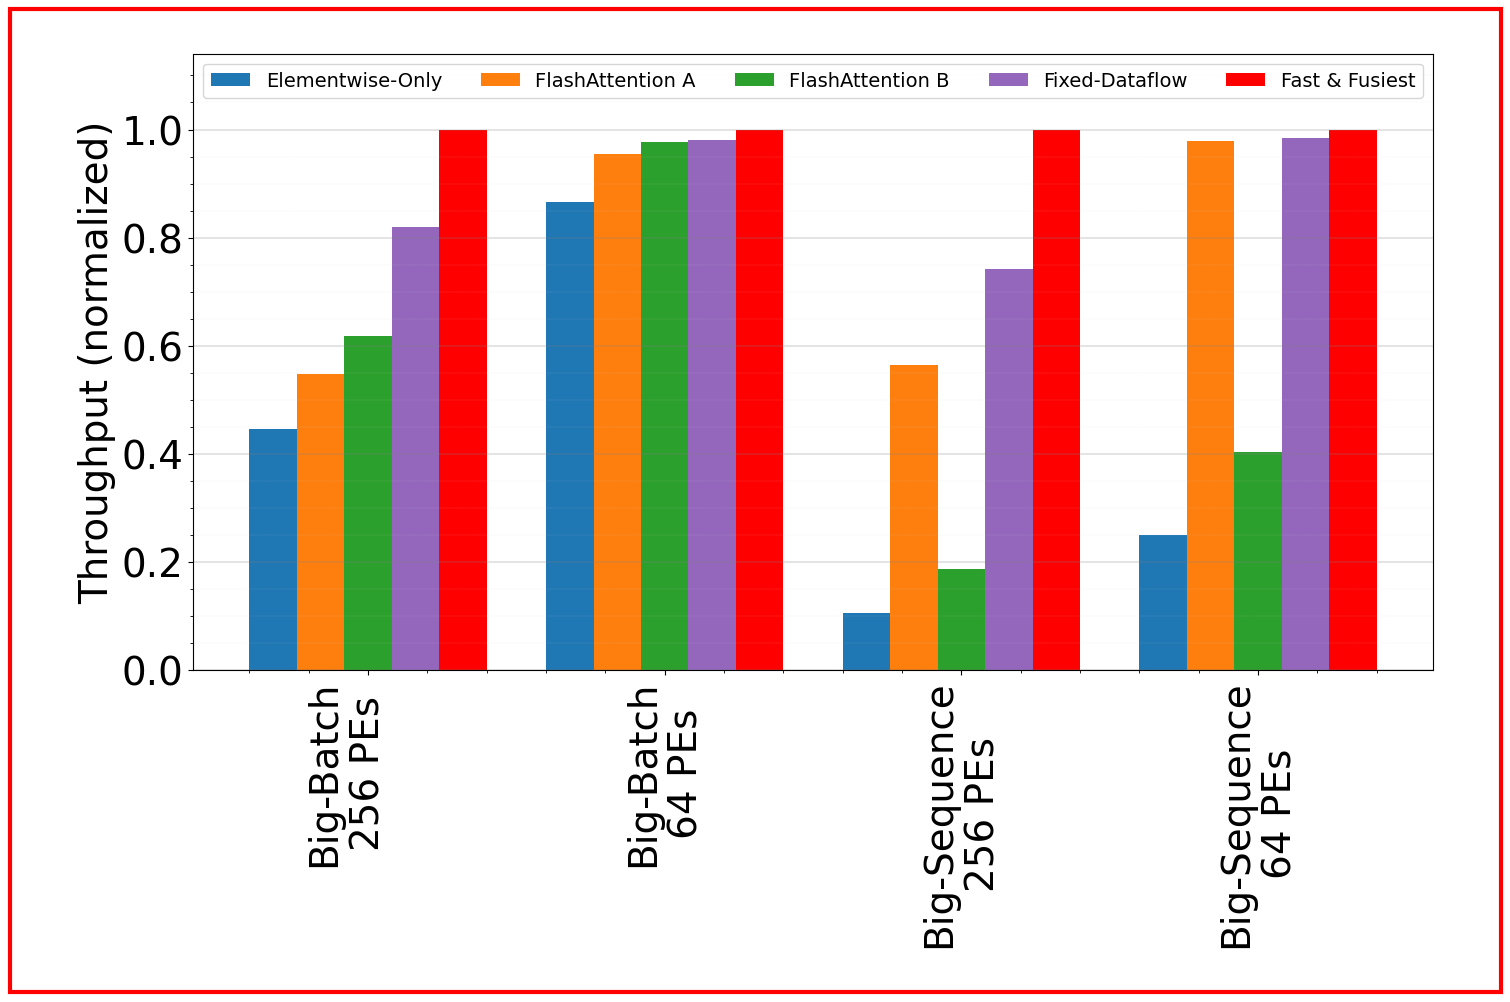

In [4]:

import matplotlib.pyplot as plt
plt.style.use('default')
plt.rcParams.update({'font.size': 28})

def plot_default_formatting(ax, grid_axis='both'):
    ax.tick_params(axis='both', which='major')#, labelsize=20)
    ax.tick_params(axis='both', which='minor')#, labelsize=20)
    legend = ax.legend()
    legend.get_frame().set_facecolor('white')
    legend.get_frame().set_edgecolor('black')
    # Set legend ncols to 5
    for spine in ax.spines.values():
        spine.set_edgecolor('black')
    ax.legend(fontsize=14, ncols=5)
    ax.minorticks_on()
    ax.grid(axis=grid_axis, which='major', linestyle='-', linewidth='0.3', color='gray')
    ax.grid(axis=grid_axis, which='minor', linestyle='--', linewidth='0.1', color='lightgray')
    

colors = [
    "#1f77b4",
    "#ff7f0e",
    "#2ca02c",
    "#9467bd",
    "#ff0000",
]

def make_bar_chart(
    data,
    title,
    xlabel,
    ylabel,
    y_scale,
    output_file=None,
    normalize: bool = False,
    ylim=(None, None),
    xlim=(None, None),
):
    """
    Create a bar chart from the given data and save it as a PDF.
    """
    plt.figure(figsize=(16, 8))
    
    if isinstance(data, dict) and isinstance(next(iter(data.values())), dict):
        bar_width = 0.8 / len(data)
        keys = list(next(iter(data.values())).keys())
        x = range(len(keys))
        first = next(iter(data.values()))
            
        for i, (label, values) in enumerate(data.items()):
            bar_positions = [pos + i * bar_width for pos in x]
            to_plot = values
            if normalize:
                to_plot = {k: v / first[k] for k, v in values.items()}
            bars = plt.bar(bar_positions, to_plot.values(), width=bar_width, label=label, color=colors[i])
        plt.xticks([pos + (len(data) - 1) * bar_width / 2 for pos in x], keys)
        # plt.legend(loc='upper right', fontsize=10)
        plt.legend(fontsize=10, ncol=len(data), loc='upper center')
    else:
        keys = list(data.keys())
        bars = plt.bar(keys, data.values())

    # Set logarithmic scale for Y-axis if specified
    if y_scale == 'log':
        plt.yscale('log')

    # Add labels and title
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.ylim(ylim)
    plt.xlim(xlim)

    # Rotate X-axis labels vertically
    plt.xticks(rotation=90)
    
    plot_default_formatting(plt.gca(), grid_axis='y')

    ax = plt.gca()
    fig = plt.gcf()
    bbox = ax.get_tightbbox(fig.canvas.get_renderer())
    x0, y0, width, height = bbox.transformed(fig.transFigure.inverted()).bounds
    # slightly increase the very tight bounds:
    xpad = 0.05 * width
    ypad = 0.05 * height
    fig.add_artist(plt.Rectangle((x0-xpad, y0-ypad), width+2*xpad, height+2*ypad, edgecolor='red', linewidth=3, fill=False))
    
    if output_file is not None:
        with open(output_file, 'wb') as f:
            plt.savefig(f, format='pdf', bbox_inches='tight')

    # Show the plot
    plt.show()

# Now we're going to make a line chart. Have the X axis be (Number of MACs, GLB size)
# and the Y axis be EDP. We'll plot a line for each parameterization.

# # Get the keys from parameterization2edp
# keys = list(parameterization2edp.keys())
# entries = {}
# for key in keys:
#     print(key)
#     parts = key.split(" ")
#     mac_dims = parts[-1]
#     n_pes = int(parts[-2])
#     n_macs = int(mac_dims.split("x")[0]) * int(mac_dims.split("x")[1]) * n_pes
#     entry = " ".join(parts[:-2])
#     n_macs = f"{n_macs // 1024}k"
#     entries.setdefault(entry, {})[n_macs] = 1 / (parameterization2edp[key] / 1.05e9 * 1000)
    
# max_throughput = max(max(e.values()) for e in entries.values())
# entries = {k: {k2: v2 / max_throughput for k2, v2 in v.items()} for k, v in entries.items()}
    
# all_keys = set.union(*[set(entries.keys()) for entries in entries.values()])
# for name, e in entries.items():
#     for k in all_keys:
#         if k not in e:
#             e[k] = 0
#     entries[name] = {k: e[k] for k in sorted(e.keys(), key=lambda x: int(x.split("k")[0]))}

entries = {}

name_changes = {
    "Unfused": "Elementwise-Only",
    "FlashAttention A": "FlashAttention A",
    "FlashAttention B": "FlashAttention B",
    "FFM": "Fast & Fusiest",
}

for k, v in results.items():
    entries[k] = {name_changes.get(k2, k2): 1/v[k2] if v[k2] else 0 for k2 in v}
    max_val = max(entries[k].values())
    for k2, v2 in entries[k].items():
        entries[k][k2] = v2 / max_val if max_val else 0
        
# Transpose everything
entries2 = {}
for k, v in entries.items():
    for k2, v2 in v.items():
        entries2.setdefault(k2, {})[k] = v2
entries = entries2
        
# Print as a table
for name, e in entries2.items():
    print(f"{name}: {e}")

make_bar_chart(entries, title=None, xlabel=None, ylabel="Throughput (normalized)", y_scale='linear', output_file="mapsapce_compare.pdf", normalize=False, ylim=(0, 1.14), xlim=(None, None))

In [3]:
# # glb_MB = 128
# # sram_MB = 4
# # parameterization = ""

# # cur_area_budget = area_budget
# # glb_size = glb_MB * 1024 * 1024 * 8
# # glb = CactiSRAM(technology="7nm", width=1024, depth=glb_size // 1024)
# # cur_area_budget -= glb.get_area()
# # # for sram_MB in [0.25, 0.5, 1, 1.5, 2, 2.5, 3, 3.5, 4]:
# # sram_size = sram_MB * 1024 * 1024 * 8
# # llb = CactiSRAM(technology="7nm", width=128, depth=sram_size // 128)
# # remaining_area = cur_area_budget / 4 - llb.get_area() # Per-MXU
# # mac_dims = int((remaining_area / mac_area) ** 0.5)
# # print(f"Global buffer: {glb_MB} MB, Local buffer: {sram_MB} MB, MAC dims: {mac_dims}x{mac_dims}")
# # print(f'GLB read energy: {glb.read()}. LLB read energy: {llb.read()}')

from fastfusion.mapper.FFM.exploration.mapper_multi_einsum import get_per_tensor_size, get_num_computes
for tensor, size in sorted(get_per_tensor_size(spec).items(), key=lambda x: x[1], reverse=True):
    print(f"{tensor}: {size}")
print(f"Number of computes: {get_num_computes(spec)}")

NameError: name 'spec' is not defined

In [4]:
from fastfusion.mapper.FFM.exploration.mapper_multi_einsum import get_rank_variable_bounds_for_all_einsums

parameterization2latencycols: list[dict[str, float]] = []
for p, mappings in parameterization2mappings.items():
    mappings._data = mappings.data.sort_values(by="metric_Latency", ascending=True)
    rank_variable_bounds = get_rank_variable_bounds_for_all_einsums(spec)

    row = {
        "Parameterization": p,
    }
    for col in mappings.data.columns:
        print(f'{col}: {mappings.data.iloc[0][col]}')
        # if "Latency" in col:
        # if "metric_Latency" in col:
        if "Latency" in col:
        # if "metric_Energy" in col:
            row[col] = mappings.data.iloc[0][col]
    parameterization2latencycols.append(row)

    # from fastfusion.mapper.FFM.visualization import make_mapping
    # from IPython.display import SVG
    # newmapping = make_mapping(mappings.data.iloc[0], spec.workload.einsum_names, get_rank_variable_bounds_for_all_einsums(spec))
    # for col in mappings.data.columns:
    #     print(f'{col}: {mappings.data.iloc[0][col]}')

    # display(SVG(newmapping.render()))
    
from pandas import DataFrame
df = DataFrame(parameterization2latencycols)
import pandas as pd
pd.set_option('display.max_columns', None)
df
    
# {'n1'}-1 || [GlobalBuffer] T1 sz 0 above 1
# TODO: Re-add -1 to the mapper one eisnum freenig
# compatibility2sims['Matmul1']["{'n1'}-1 || [GlobalBuffer] T1 sz 0 above 1"]
# Above 1: 8192
# Above 2: 8321
# compatibility2sims['Matmul2']["{'n1'}-1 || [GlobalBuffer] T1 sz 0 above 1, [GlobalBuffer] T2 sz 0 above 0"]

FFB__tile_shape0: 16384.0
FFB__tile_shape1: 4096.0
FFB__tile_shape2: 1.0
FFB__tile_shape3: 64.0
FFB__tile_shape4: 128.0
FFB__tile_shape5: 1.0
FFB__tile_shape6: 1.0
FFB__tile_shape7: 128.0
FFB__tile_shape8: 1.0
FFB__tile_shape9: 1.0
FFBmetric_Latency: 2097152.0
FFBcompute_Latency: 2097152.0
FFBGlobalBuffer_Latency: 0
FFBMainMemory_Latency: 1262389.868401211
FFBmetric_Energy: 17.83001516081154
FFB__MAPPING: type=None nodes=[Storage(type=None, tensors=['WFFB'], memory='MainMemory', memory_object=Memory(type=None, name='MainMemory', attributes=MemoryAttributes(type=None, technology='7nm', global_cycle_seconds=1e-09, n_instances=1, energy_scale=1, area_scale=1, energy=None, area=1, datawidth=8, size=9999999999999, multiple_buffering=1, shared_read_write_bandwidth=4678.0952380952385, read_bandwidth=inf, write_bandwidth=inf, version='0.5', width=4678), spatial=Spatial(type=None, fanout={}), constraints=ConstraintGroup(type=None, name=None, spatial=[], temporal=Temporal(type=None, version='0.5

Imetric_Energy: 0.00184348049408
IRESOURCE_GlobalBuffer_LEVEL_2: nan
IRESOURCE_GlobalBuffer_LEVEL_1: 16777728.0
I__MAPPING: type=None nodes=[Storage(type=None, tensors=['I_in'], memory='MainMemory', memory_object=Memory(type=None, name='MainMemory', attributes=MemoryAttributes(type=None, technology='7nm', global_cycle_seconds=1e-09, n_instances=1, energy_scale=1, area_scale=1, energy=None, area=1, datawidth=8, size=9999999999999, multiple_buffering=1, shared_read_write_bandwidth=4678.0952380952385, read_bandwidth=inf, write_bandwidth=inf, version='0.5', width=4678), spatial=Spatial(type=None, fanout={}), constraints=ConstraintGroup(type=None, name=None, spatial=[], temporal=Temporal(type=None, version='0.5', reuse='All', loop_bounds=[], rmw_first_update=[]), storage=Storage(type=None, bypass='I | Q | K | V | QK | QK_softmax', keep='All() - (I | Q | K | V | QK | QK_softmax)', coalesce='All', tile_shape=[]), dataflow=Dataflow(type=None, storage_orders=[])), component_class='DRAM', enable

,Parameterization,FFBmetric_Latency,FFBcompute_Latency,FFBGlobalBuffer_Latency,FFBMainMemory_Latency,FFAmetric_Latency,FFAcompute_Latency,FFAGlobalBuffer_Latency,FFAMainMemory_Latency,Zmetric_Latency,Zcompute_Latency,ZGlobalBuffer_Latency,ZMainMemory_Latency,AVmetric_Latency,AVcompute_Latency,AVGlobalBuffer_Latency,AVMainMemory_Latency,QK_softmaxmetric_Latency,QK_softmaxcompute_Latency,QK_softmaxGlobalBuffer_Latency,QK_softmaxMainMemory_Latency,QKmetric_Latency,QKcompute_Latency,QKGlobalBuffer_Latency,QKMainMemory_Latency,Qmetric_Latency,Qcompute_Latency,QGlobalBuffer_Latency,QMainMemory_Latency,Kmetric_Latency,Kcompute_Latency,KGlobalBuffer_Latency,KMainMemory_Latency,Vmetric_Latency,Vcompute_Latency,VGlobalBuffer_Latency,VMainMemory_Latency,Imetric_Latency,Icompute_Latency,IGlobalBuffer_Latency,IMainMemory_Latency,metric_Latency
0,Unfused 64 128x128,2.097152e+06,2097152.0,0,1.262390e+06,2.097152e+06,2097152.0,0,1.262390e+06,524288.000000,524288.0,0,487741.540064,1.377153e+06,65536.0,0,1.377153e+06,8388608.0,8388608.0,0,1.836203e+06,1.377153e+06,65536.0,0,1.377153e+06,524288.000000,524288.0,0,487741.540064,524288.000000,524288.0,0,487741.540064,524288.000000,524288.0,0,487741.540064,2097152.0,2097152.0,0,459050.861237,1.953152e+07
1,Fixed-Dataflow 64 128x128,2.097152e+06,2097152.0,0,8.033390e+05,2.097152e+06,2097152.0,0,5.738136e+05,524288.000000,524288.0,0,258216.109446,2.295254e+05,131072.0,0,2.295254e+05,8388608.0,8388608.0,0,NaN,2.295254e+05,65536.0,0,2.295254e+05,524288.000000,524288.0,0,28690.678827,524288.000000,524288.0,0,258216.109446,524288.000000,524288.0,0,258216.109446,2097152.0,2097152.0,0,229525.430618,1.723627e+07
2,FlashAttention A 64 128x128,2.097152e+06,2097152.0,0,1.262390e+06,2.097152e+06,2097152.0,0,1.262390e+06,524288.000000,524288.0,0,487741.540064,4.590509e+05,65536.0,0,4.590509e+05,8388608.0,8388608.0,0,NaN,4.590509e+05,65536.0,0,4.590509e+05,524288.000000,524288.0,0,487741.540064,524288.000000,524288.0,0,487741.540064,524288.000000,524288.0,0,487741.540064,2097152.0,2097152.0,0,459050.861237,1.769532e+07
3,FlashAttention B 64 128x128,2.097152e+06,2097152.0,0,1.262390e+06,2.097152e+06,2097152.0,0,1.262390e+06,524288.000000,524288.0,0,487741.540064,2.295254e+05,65536.0,0,2.295254e+05,8388608.0,8388608.0,0,NaN,6.553600e+04,65536.0,0,NaN,524288.000000,524288.0,0,28690.678827,524288.000000,524288.0,0,28690.678827,524288.000000,524288.0,0,28690.678827,2097152.0,2097152.0,0,229525.430618,1.707228e+07
4,FFM 64 128x128,2.097152e+06,2097152.0,0,6.885763e+05,2.097152e+06,2097152.0,0,4.590509e+05,524288.000000,524288.0,0,114762.715309,6.553600e+04,65536.0,0,NaN,8388608.0,8388608.0,0,NaN,6.553600e+04,65536.0,0,NaN,524288.000000,524288.0,0,28690.678827,524288.000000,524288.0,0,28690.678827,524288.000000,524288.0,0,28690.678827,2097152.0,2097152.0,0,229525.430618,1.690829e+07
5,Unfused 256 128x128,1.262390e+06,1048576.0,0,1.262390e+06,1.262390e+06,1048576.0,0,1.262390e+06,487741.540064,131072.0,0,487741.540064,1.377153e+06,16384.0,0,1.377153e+06,2097152.0,2097152.0,0,1.836203e+06,1.377153e+06,16384.0,0,1.377153e+06,487741.540064,131072.0,0,487741.540064,487741.540064,131072.0,0,487741.540064,487741.540064,131072.0,0,487741.540064,524288.0,524288.0,0,459050.861237,9.851491e+06
6,Fixed-Dataflow 256 128x128,8.033390e+05,524288.0,0,8.033390e+05,5.738136e+05,524288.0,0,5.738136e+05,258216.109446,131072.0,0,258216.109446,2.295254e+05,131072.0,0,2.295254e+05,2097152.0,2097152.0,0,NaN,2.295254e+05,131072.0,0,2.295254e+05,131072.000000,131072.0,0,28690.678827,258216.109446,131072.0,0,258216.109446,258216.109446,131072.0,0,258216.109446,524288.0,524288.0,0,229525.430618,5.363364e+06
7,FlashAttention A 256 128x128,1.262390e+06,1048576.0,0,1.262390e+06,1.262390e+06,1048576.0,0,1.262390e+06,487741.540064,131072.0,0,487741.540064,4.590509e+05,16384.0,0,4.590509e+05,2097152.0,2097152.0,0,NaN,4.590509e+05,131072.0,0,4.590509e+05,487741.540064,131072.0,0,487741.540064,487741.540064,131072.0,0,487741.540064,487741.540064,131072.0,0

In [5]:
from fastfusion.mapper.FFM.exploration.mapper_multi_einsum import get_rank_variable_bounds_for_all_einsums

mac_dims = int((((area_budget - glb.get_area()) / 4 - llb.get_area()) / mac_area)** 0.5)
mappings = list(parameterization2mappings.values())[0]
mappings._data = mappings.data.sort_values(by="metric_Latency", ascending=True).head()
rank_variable_bounds = get_rank_variable_bounds_for_all_einsums(spec)
from fastfusion.mapper.FFM.visualization import make_mapping
from IPython.display import SVG
newmapping = make_mapping(mappings.data.iloc[0], spec.workload.einsum_names, get_rank_variable_bounds_for_all_einsums(spec))
a = {}
for col in mappings.data.columns:
    print(f'{col}: {mappings.data.iloc[0][col]}')
    if "Latency" in col:
        a[col] = mappings.data.iloc[0][col]
display(SVG(newmapping.render()))

NameError: name 'area_budget' is not defined

In [ ]:
assert False

from fastfusion.mapper.FFM.exploration.mapper_multi_einsum import get_rank_variable_bounds_for_all_einsums

sram_size = 0.5 * 1024 * 1024 * 8
llb = CactiSRAM(technology="7nm", width=128, depth=sram_size // 128)
mac_dims = int((((area_budget - glb.get_area()) / 4 - llb.get_area()) / mac_area)** 0.5)
mappings = get_fused_mappings(
    spec,
    mac_dims,
    llb,
    glb,
    return_mappings=True,
    parameterization="FFM"
)
mappings._data = mappings.data.sort_values(by="metric_Latency", ascending=True).head()
rank_variable_bounds = get_rank_variable_bounds_for_all_einsums(spec)
from fastfusion.mapper.FFM.visualization import make_mapping
from IPython.display import SVG
newmapping = make_mapping(mappings.data.iloc[0], spec.workload.einsum_names, get_rank_variable_bounds_for_all_einsums(spec))
b = {}
for col in mappings.data.columns:
    print(f'{col}: {mappings.data.iloc[0][col]}')
    if "Latency" in col:
        b[col] = mappings.data.iloc[0][col]
display(SVG(newmapping.render()))

In [ ]:
df = pd.DataFrame([a, b])
df